In [1]:
import numpy as np
import os
import networkx as nx
from matplotlib import pyplot as plt

In [2]:
# change the directory to the root directory

os.chdir("../")

In [3]:
from datagen.generateDataset import Dataset 
from models.resblock_trainer import resflow_train_test_wrapper

from utils import *

## Generating training and validation data

In [4]:
dataset_gen = Dataset(
    n_nodes=10,
    expected_density=2, 
    n_samples=1000,
    n_experiments=10,
    sem_type="lin", # change to nnl for nonlinear SEM
    act_fun='none',
    enforce_dag=False, 
    contractive=True
)

datasets = dataset_gen.generate(interventions=True)

In [5]:
# Training data contains all single node experiments
training_data = datasets
intervention_sets = dataset_gen.targets 

Text(0.5, 1.0, 'Edge weights')

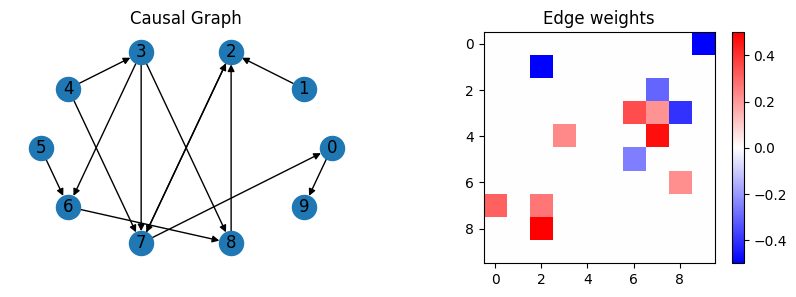

In [6]:
# Visualizing the graph

graph = dataset_gen.graph
sem = dataset_gen.gen_model

pos = nx.circular_layout(graph)

fig, axs = plt.subplots(1, 2)
fig.set_size_inches(10, 3)

nx.draw(graph, with_labels=True, pos=pos, ax=axs[0])

axs[1].imshow(sem.weights, cmap='bwr', vmin=-0.5, vmax=0.5)

plt.colorbar(axs[1].images[0], ax=axs[1])

axs[0].set_title("Causal Graph")
axs[1].set_title("Edge weights")

## Train the model

In [7]:
model = resflow_train_test_wrapper(
    n_nodes=10,
    batch_size=512,
    l1_reg=True, 
    lambda_c=1e-3, # sparsity penalization coef
    fun_type='gst-mlp', # Gumble-softmax masking function
    act_fun='none',
    lr=1e-1, 
    epochs=200, # change to a higher number for better accuracy,
    v=False, 
    inline=True, 
    n_hidden=0,
    optim='adam'
)

Initializing the model
Number of Parameters : 212


In [8]:
model.train(training_data, intervention_sets, batch_size=512)

Starting Training


/home/muralikgs/miniconda3/envs/causal-discovery/lib/python3.13/site-packages/torch/autograd/graph.py:824: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:181.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Text(0.5, 1.0, 'Estimated Graph')

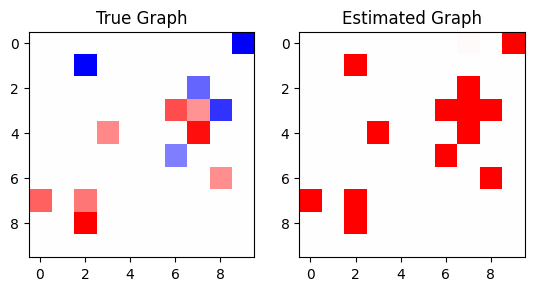

In [13]:
fig, axs = plt.subplots(1, 2)

axs[0].imshow(sem.weights, cmap='bwr', vmin=-0.5, vmax=0.5)
axs[0].set_title("True Graph")

axs[1].imshow(model.model.f.get_w_adj().detach().cpu().numpy(), cmap='bwr', vmin=-1, vmax=1)
axs[1].set_title("Estimated Graph")

In [14]:
# Computing the error metric
shd = compute_shd(np.abs(sem.weights) > 0, model.model.f.get_w_adj().detach().cpu().numpy() > 0.7)

In [15]:
print(f"SHD: {shd[0]}")

SHD: 0.0
